In [64]:
import numpy as np
import pandas as pd

import os
print(os.listdir("./DATA"))

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

['sample_submission.csv', 'test.csv', 'test_labels.csv', 'train.csv']


In [65]:
train = pd.read_csv('./DATA/train.csv')
test = pd.read_csv('./DATA/test.csv')
subm = pd.read_csv('./DATA/sample_submission.csv')

In [66]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [67]:
train.shape

(159571, 8)

#### check data with simple EDA

In [68]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [139]:
train.comment_text[2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

In [69]:
train_length = train.comment_text.apply(len)

In [70]:
train_length

0          264
1          112
2          233
3          622
4           67
5           65
6           44
7          115
8          472
9           70
10        2875
11          56
12         319
13         819
14         219
15         610
16          57
17          48
18         118
19         440
20         266
21          58
22         543
23          97
24        1409
25         172
26         288
27         343
28         119
29          78
          ... 
159541     346
159542     164
159543      80
159544      19
159545     105
159546     534
159547      30
159548      27
159549      25
159550     173
159551     196
159552      92
159553     888
159554     182
159555     119
159556      57
159557     429
159558     134
159559     357
159560    1889
159561    1147
159562    1015
159563     394
159564     369
159565     653
159566     295
159567      99
159568      81
159569     116
159570     189
Name: comment_text, Length: 159571, dtype: int64

In [71]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


<function matplotlib.pyplot.show(*args, **kw)>

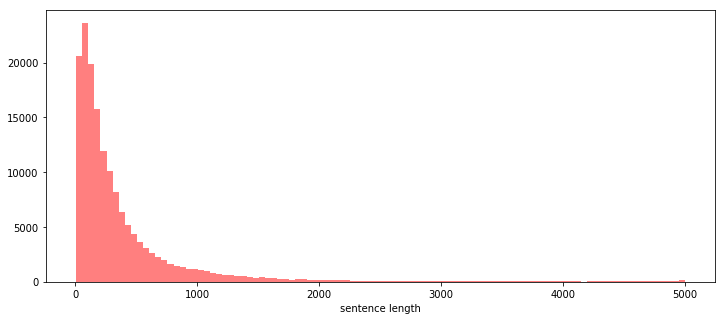

In [72]:
plt.figure(figsize = (12, 5))
plt.hist(train_length, bins = 100, alpha = 0.5, color = 'r')
plt.xlabel('sentence length')
plt.ylabel('')
plt.show

In [141]:
print('max length :', np.max(train_length))
print('min length :', np.min(train_length))
print('mean length :', np.mean(train_length))
print('75 % percentile :', np.percentile(train_length, 50))
print('85 % percentile :', np.percentile(train_length, 85))
print('std length :', np.std(train_length))

max length : 5000
min length : 6
mean length : 394.0732213246768
75 % percentile : 205.0
85 % percentile : 663.0
std length : 590.7184309382149


In [74]:
train.comment_text.isna().sum()
test.comment_text.isna().sum()

0

In [75]:
X = train.comment_text
y = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate']].values
test = test.comment_text

In [13]:
num_words = 20000
max_len = 200
emb_size = 128

In [78]:
tok = Tokenizer(num_words = num_words)
tok.fit_on_texts(list(X))

In [79]:
X = tok.texts_to_sequences(X)
test = tok.texts_to_sequences(test)

In [80]:
X = sequence.pad_sequences(X, maxlen = max_len, padding='post')
X_test = sequence.pad_sequences(test, maxlen = max_len, padding = 'post')

In [91]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()

In [ ]:
model.add()

In [114]:
inp = Input(shape=(max_len, )) #maxlen=200 as defined earlier
embed_size = 128
x = Embedding(num_words, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [144]:
y[0]

array([0, 0, 0, 0, 0, 0], dtype=int64)

In [116]:
batch_size = 32
epochs = 2
model.fit(X,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 591s 4ms/step - loss: 0.0641 - acc: 0.9782 - val_loss: 0.0492 - val_acc: 0.9821
Epoch 2/2
143613/143613 [==============================] - 587s 4ms/step - loss: 0.0449 - acc: 0.9832 - val_loss: 0.0473 - val_acc: 0.9826


In [100]:
file_path = 'save_best'
checkpoint = ModelCheckpoint(file_path, monitor = 'val_loss', verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)

In [103]:
model.fit(X,y, epochs=100, batch_size=32)

ValueError: An operation has `None` for gradient. Please make sure that all of your ops have a gradient defined (i.e. are differentiable). Common ops without gradient: K.argmax, K.round, K.eval.

In [106]:
X.shape

(159571, 200)

In [107]:
y.shape

(159571, 6)

In [120]:
prediction = model.predict(X_test)

In [129]:
prediction

array([[9.9693573e-01, 2.9139790e-01, 9.5797753e-01, 6.9460422e-02,
        8.9626491e-01, 1.7496234e-01],
       [8.9803338e-04, 4.4703484e-07, 1.5681982e-04, 1.8477440e-06,
        6.9260597e-05, 5.0008297e-05],
       [1.9486248e-03, 1.4007092e-06, 3.1951070e-04, 6.2882900e-06,
        1.4093518e-04, 1.0240078e-04],
       ...,
       [4.5722723e-04, 2.0861626e-07, 7.5697899e-05, 8.6426735e-07,
        3.1590462e-05, 3.0249357e-05],
       [1.3017356e-03, 6.8545341e-07, 1.6692281e-04, 3.1590462e-06,
        1.1771917e-04, 8.4578991e-05],
       [9.6320653e-01, 4.2360574e-02, 8.6932349e-01, 5.9855878e-03,
        5.1213932e-01, 2.5304914e-02]], dtype=float32)

In [132]:
list_of_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [133]:
# sample_submission = pd.read_csv("../input/sample_submission.csv")
subm[list_of_classes] = prediction
subm.to_csv("toxic_comment_classification.csv", index=False)

In [ ]:
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=max_text_length))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto 6 output layers, and squash it with a sigmoid:
model.add(Dense(6))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

In [ ]:
inp = Input(shape=(max_len, )) #maxlen=200 as defined earlier
embed_size = 128
x = Embedding(num_words, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [147]:
from keras.layers import Dense

In [145]:
model = Sequential()

In [155]:
model.add(Dense(5, input_dim = max_len, activation = 'relu'))
model.add(Embedding(num_words, embed_size))
model.add(LSTM(60, return_sequences=True))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(6,activation = 'relu'))
model.add(Dense(6,activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['acc'])